# Set path - Init

First, define the PYTHONPATH variable appropriately

In [1]:
import sys 
sys.path.append('/home/pierre-edouard/Desktop/ICL/Git_LHCb')

import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
from scipy import interpolate
import time 
from tqdm import tqdm
import csv
import tensorflow.compat.v2 as tf 

import b_meson_fit.signal as bmfs  
import b_meson_fit as bmf 
from toy_minuit import toy
from test_iminuit import amplitude_latex_names ,amplitude_names, LaTex_labels , Standard_labels  , fix_array , fix_alphas , fix_one_alpha , fix_alpha_beta  ,fix_alpha_beta_gamma5

# I ) Background sampling  


## Testing the background sampling  

Few plots of the distribution of angular observables sampled from our background pdfs

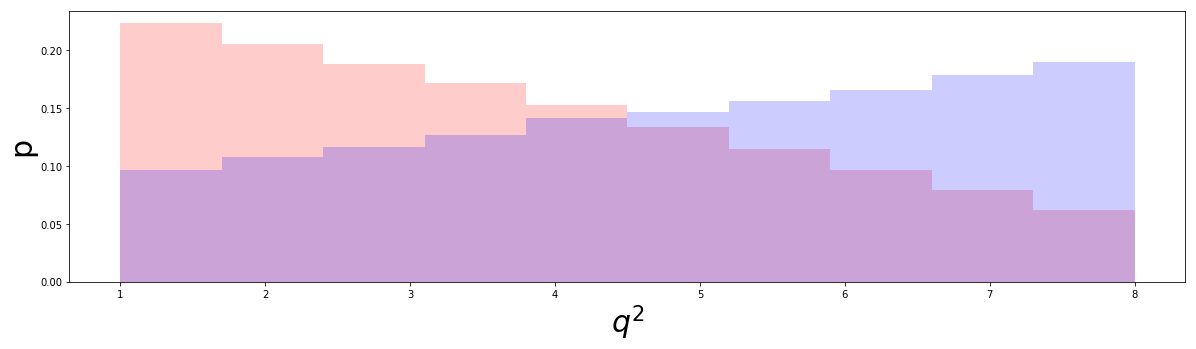

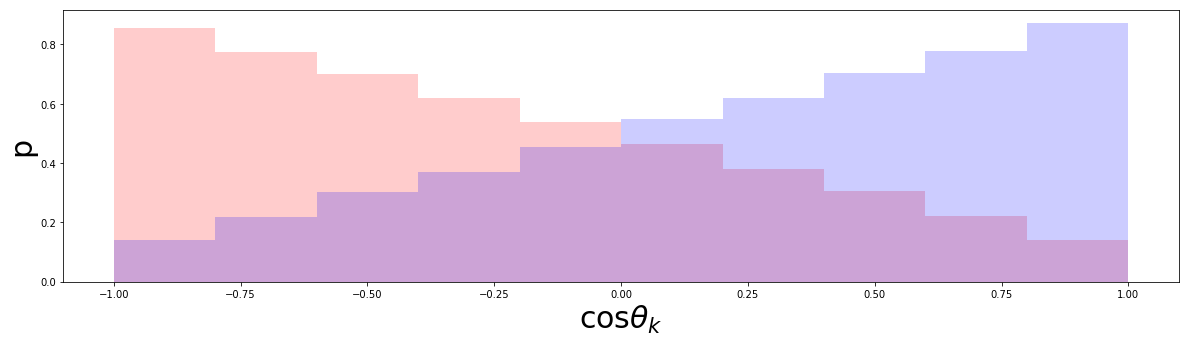

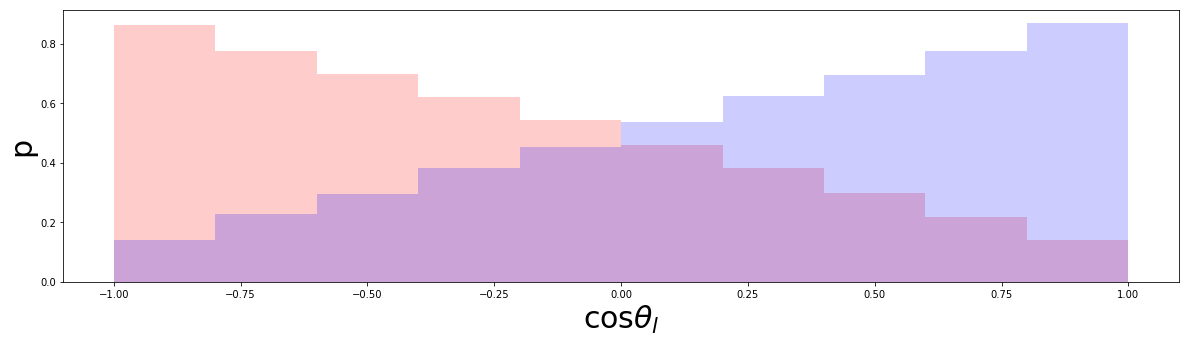

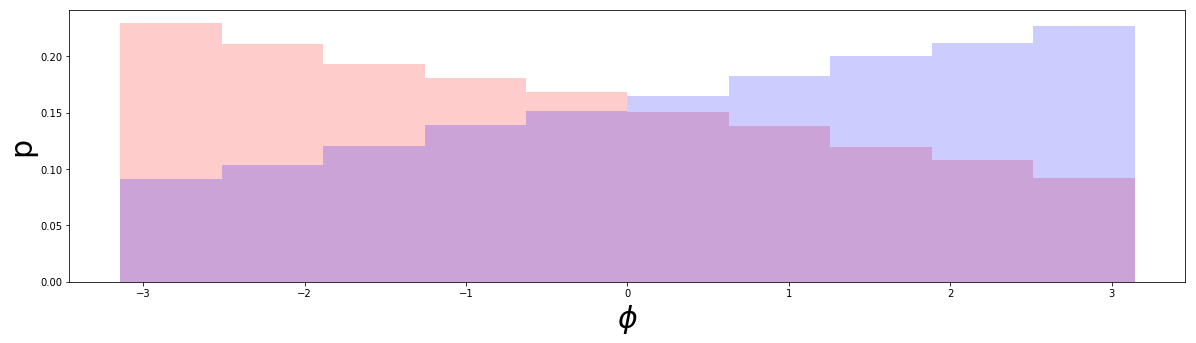

In [2]:
from b_meson_fit.signal import decay_rate 
from b_meson_fit.signal import generate_background 

CoeffBCK0_bis = [
    [55.,+10.],
    [100.,+80.],
    [100.,+80.],
    [100,+15.]
]

CoeffBCK0 = [
    [100.,-10.],
    [100.,-80.],
    [100.,-80.],
    [100,-15.]
]

#initial coefficients 
A_SM=bmf.coeffs.fit(bmf.coeffs.fit_initialization_scheme_default , current_signal_model='SM')
CoeffSM=[A_SM[i].numpy() for i in range(len(A_SM))]

A_NP=bmf.coeffs.fit(bmf.coeffs.fit_initialization_scheme_default , current_signal_model='NP')
CoeffNP=[A_NP[i].numpy() for i in range(len(A_NP))]

plt.rcParams["figure.figsize"] = (20,5)
n_bins=10
labels=[r'$q^{2}$' , r'cos$\theta_{k}$' , r'cos$\theta_{l}$' , r'$\phi$' ]




events_bck0 = generate_background(CoeffBCK0 , events_total=100000)
events_bck1 = generate_background(CoeffBCK0_bis , events_total=100000)

for j in range(4):
    ax=plt.gca()
    plt.hist(events_bck0[:,j] , bins=n_bins , alpha=0.2 , color='r' , density=True )
    plt.hist(events_bck1[:,j] , bins=n_bins , alpha=0.2 , color='b' , density=True )
    ax.set_xlabel(labels[j] , fontsize=30 )
    ax.set_ylabel('p' , fontsize=30 )
    plt.show()


## Plotting angular observables  (background included)

Plot the different angular observables and the mass of the $K\pi\mu\mu$ system with background events this time, sampled from linear pdfs. 



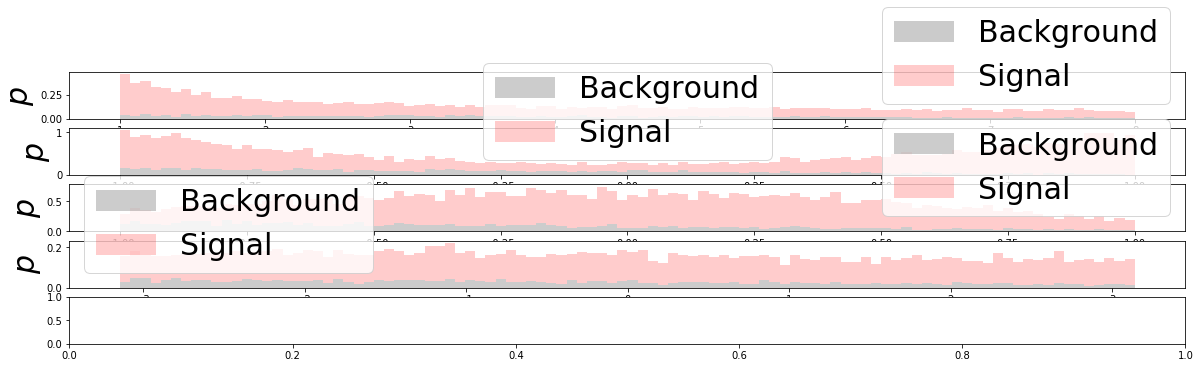

In [3]:
from b_meson_fit.signal import generate_background
from b_meson_fit.signal import generate

import b_meson_fit.signal as bmfs 
import b_meson_fit as bmf 

import tensorflow as tf 


nbins=100
CoeffBCK = [
    [100.,10.],
    [100.,10.],
    [100.,10.],
    [100.,10.]
]
bck = generate_background(CoeffBCK0, events_total=2_000, batch_size=1_000_000)
signal =  generate(CoeffSM, events_total=10_000, batch_size=1_000_000)
mix = tf.concat([bck , signal] , 0)

fig , ax = plt.subplots( 5 , 1)
plt.rcParams["figure.figsize"] = (20,50)


for j in range(4):
    ax[j].hist(  (bck[:,j] , signal[:,j])
             , bins=nbins 
             , stacked=True
             , density=True
             , color= ['black' , 'red' ]
             , label= ['Background' , 'Signal']
             , alpha=0.2)

    ax[j].set_xlabel(labels[j] , fontsize=30)
    ax[j].set_ylabel(r'$p$' , fontsize=30)
    ax[j].legend(fontsize=30)

plt.show()



In [66]:
from b_meson_fit.signal import generate_all


TRY_SM=generate_all(A_SM, CoeffBCK,events_total=100000, alpha = 0.8, poisson = False)
TRY_NP=generate_all(A_NP, CoeffBCK,events_total=100000, alpha = 0.8, poisson = False)

[[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc434145e48>


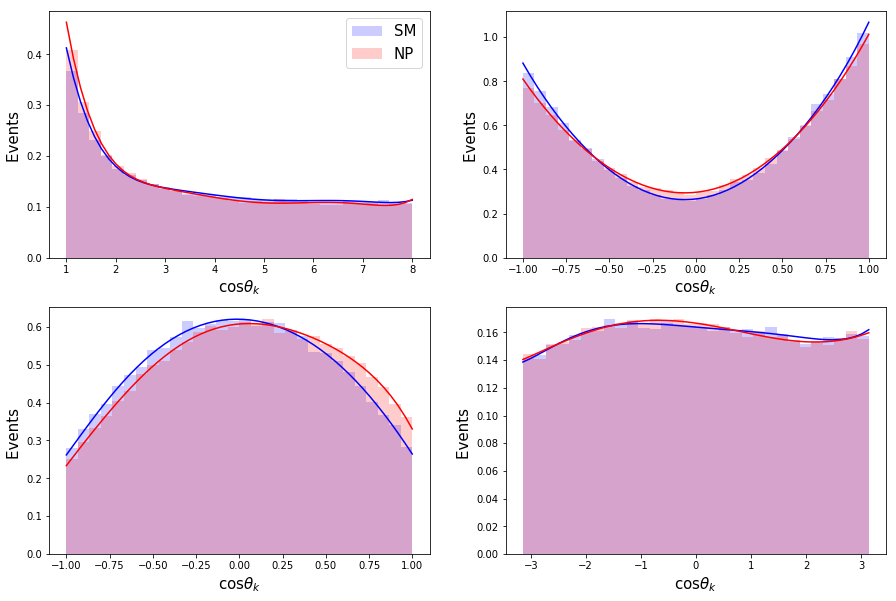

In [67]:
plt.rcParams["figure.figsize"] = (15,10)
fig , ax = plt.subplots( 2 , 2)
print(ax)
X=[0 , 0 , 1 , 1]
XX=[0 , 1 , 0 , 1]
nbins=30
for i in range(4):
    AX= ax[X[i]][XX[i]]
    if i == 0: 
        
        n , bins, patches= AX.hist(TRY_SM[:,i].numpy() , bins=nbins , density=True , color='blue' , alpha=0.2 , label='SM')
        n2 , bins2, patches2= AX.hist(TRY_NP[:,i].numpy() , bins=nbins , density=True, color='red' , alpha=0.2 , label='NP')
        AX.legend(fontsize=15)
    else :
        n , bins, patches= AX.hist(TRY_SM[:,i].numpy() , bins=nbins , density=True , color='blue' , alpha=0.2)
        n2 , bins2, patches2= AX.hist(TRY_NP[:,i].numpy() , bins=nbins , density=True, color='red' , alpha=0.2)

    centers = 0.5*(bins[1:]+ bins[:-1])
    s = np.polyfit(centers, n , 6)
    p = np.poly1d(s)
    
    centers2 = 0.5*(bins2[1:]+ bins2[:-1])
    s2 = np.polyfit(centers2, n2 , 6)
    p2 = np.poly1d(s2)   
    
    x=np.linspace(min(bins),max(bins))
    
    #plot the whole thing 
    ax[X[i]][XX[i]].plot(x , p(x) , color= 'blue')
    ax[X[i]][XX[i]].plot(x , p2(x) , color= 'red')
    
    
    AX.set_xlabel(labels[j] , fontsize=15)
    AX.set_ylabel(r'Events ' , fontsize=15)
    
plt.show()

[]

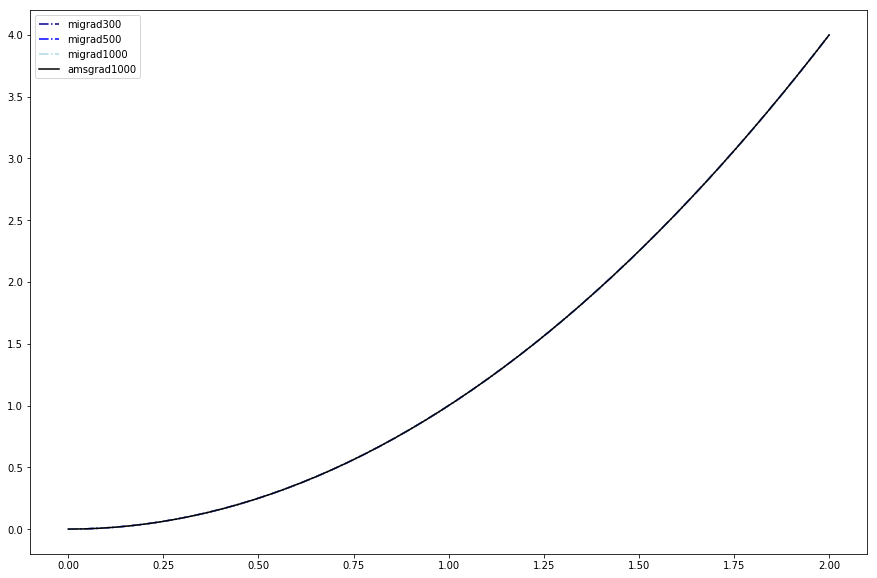

In [73]:
ax = plt.gca()
x=np.linspace(0, 2)
ax.plot(x , x**2 , '-.' , color='darkblue' , label='migrad300')
ax.plot(x , x**2 , '-.' , color='blue' , label='migrad500')
ax.plot(x , x**2 , '-.' , color='lightblue' , label='migrad1000')
ax.plot(x , x**2 , '-' , color='black' , label='amsgrad1000')


ax.legend()
plt.plot()

# II ) The Toy class 

## Signal generation

Now, create a toy and generate 100000 events following the desired model ('SM' & 'NP')

In [9]:
N_events=2_400
frac_bck=0.2
CoeffBCK0 = [
    [0.,100.],
    [0.,100.],
    [0.,100.],
    [0.,100.]
]

CoeffBCK1 = [
    [200.,-100.],
    [200,-100.],
    [200,-100.],
    [200,-100.]
]

#create toys
toySM=toy('SM')
toyNP=toy('NP')
toyMIX=toy('SM')

#generate N_events for both models  
toySM.generate(events=N_events , verbose=True)
toyNP.generate(events=N_events , verbose=True)
toyMIX.generate(events=N_events , frac_background = frac_bck, coeff_background = CoeffBCK0 , verbose=True)


#print(toySM.events)

Ideal coeffs for  SM  :  [-4.1781025, -0.15184344, 6.8183246, 0.008585378, -0.0018230017, 0.4660742, -0.23538125, -0.0043176315, 8.003745, 0.16564202, -0.013095878, -0.30668017, 3.8864067, 0.08526551, -8.197446, -0.09505176, 0.007934013, -0.07297003, -0.4235836, 0.027298994, -7.147451, 0.0, 0.0, 0.0, 7.202759, -0.2278163, 9.89863, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Time taken to generate data: 4.790227890014648
Ideal coeffs for  NP  :  [-3.4277496, -0.12410027, 6.045281, 0.009340614, -0.0019891937, 0.50341135, -0.25086978, -0.005180213, 8.636745, 0.22209263, -0.017419353, -0.5280673, 3.0646408, 0.078515366, -8.841145, -0.113660336, 0.00929356, -0.047615465, -0.933267, 0.016867112, -6.3185554, 0.0, 0.0, 0.0, 5.882883, -0.18442497, 8.101398, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Time taken to generate data: 4.545408248901367
Ideal coeffs for  SM  :  [-4

## Plotting angular observables  ( + background)

Plot the different angular observables and the mass of the $K\pi\mu\mu$ system 

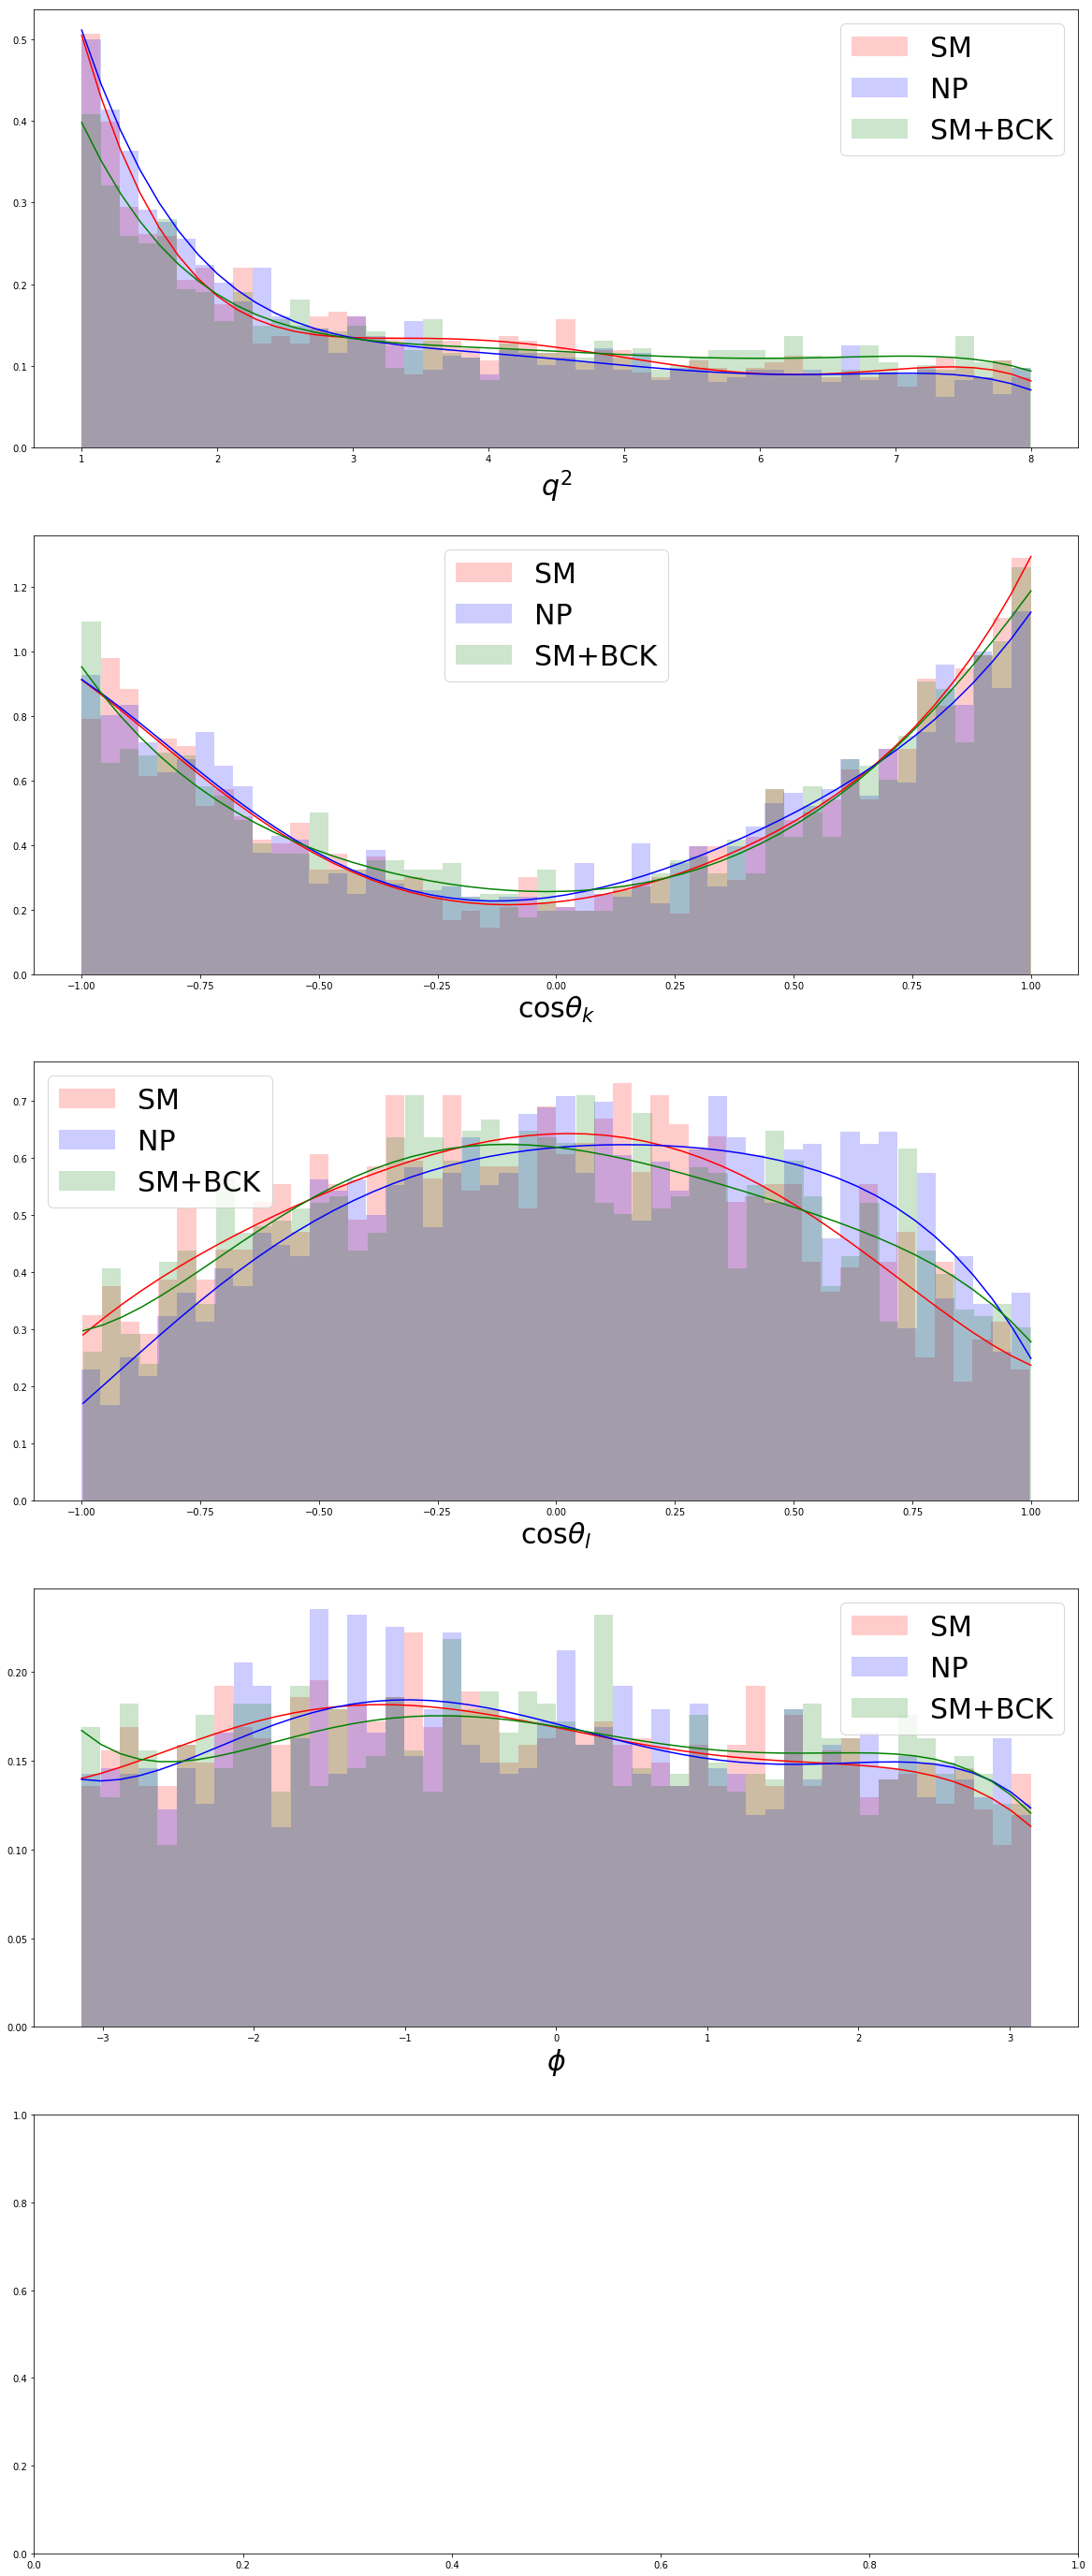

In [10]:
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d


fig , ax = plt.subplots( 5 , 1)
n_bins=50
Alpha=0.2


#Plot angular observables for SM & NP + interpolation
for j in range(4):
    
    #SM
    n , bins, patches= ax[j].hist(toySM.events[:,j] , bins=n_bins , density=True , color='red' , alpha=Alpha , label='SM')
    centers_SM = 0.5*(bins[1:]+ bins[:-1])
    s_SM = np.polyfit(centers_SM, n , 5)
    p_SM = np.poly1d(s_SM)
    
    #NP 
    n , bins, patches= ax[j].hist(toyNP.events[:,j] , bins=n_bins , density=True , color='blue' , alpha=Alpha , label='NP')
    centers_NP = 0.5*(bins[1:]+ bins[:-1])
    s_NP = np.polyfit(centers_NP, n , 5)
    p_NP = np.poly1d(s_NP)
    
    #MIX
    n , bins, patches= ax[j].hist(toyMIX.events[:,j] , bins=n_bins , density=True , color='green' , alpha=Alpha , label='SM+BCK')
    centers_MIX = 0.5*(bins[1:]+ bins[:-1])
    s_MIX = np.polyfit(centers_MIX, n , 5)
    p_MIX = np.poly1d(s_MIX)
    
    x=np.linspace(min(bins),max(bins))
    
    #plot the whole thing 
    ax[j].plot(x , p_SM(x) , color= 'red')
    ax[j].plot(x , p_NP(x) , color= 'blue')
    ax[j].plot(x , p_MIX(x) , color= 'green')
   
    ax[j].set_xlabel(labels[j] , fontsize=30)
    ax[j].legend(fontsize=30)
    

plt.show()

# III ) Minimizing the NLL 

## ... for only 2 alphas varying 



  0%|          | 0/4 [00:00<?, ?it/s]

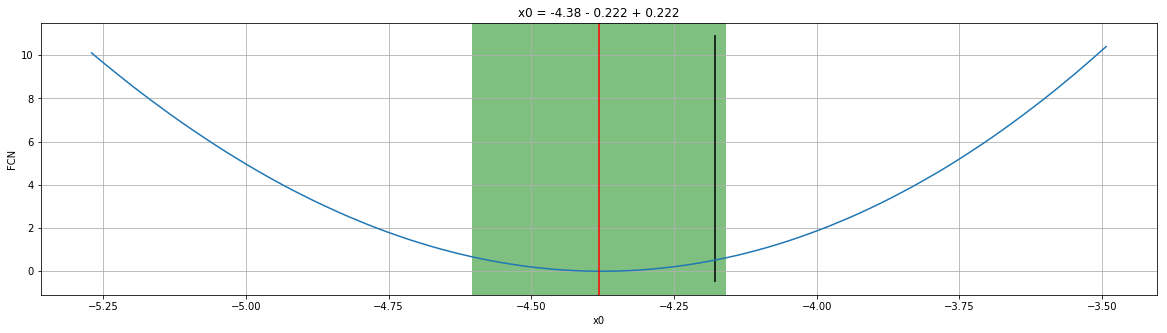

 25%|██▌       | 1/4 [00:04<00:12,  4.06s/it]

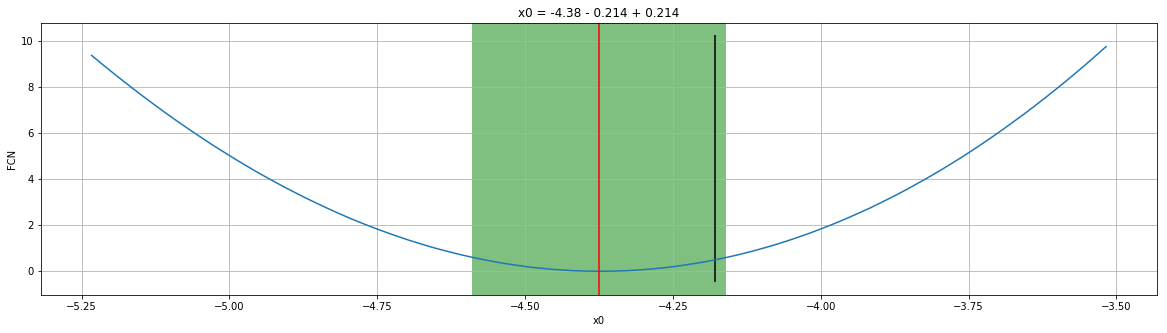

 50%|█████     | 2/4 [00:08<00:08,  4.07s/it]

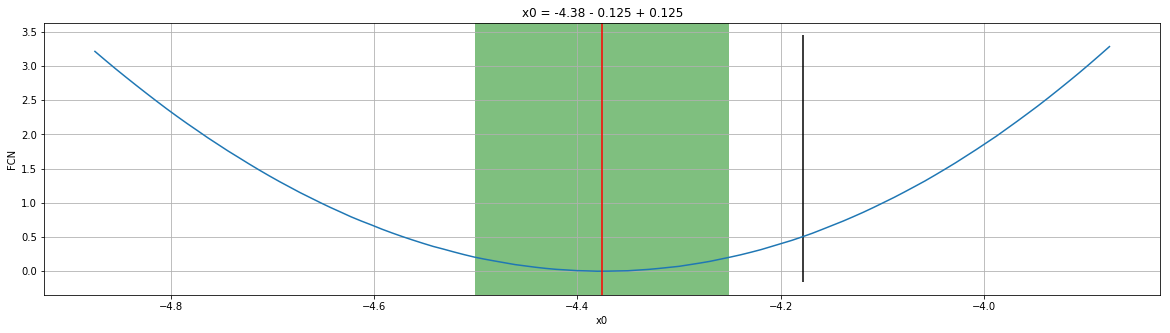

 75%|███████▌  | 3/4 [00:12<00:04,  4.03s/it]

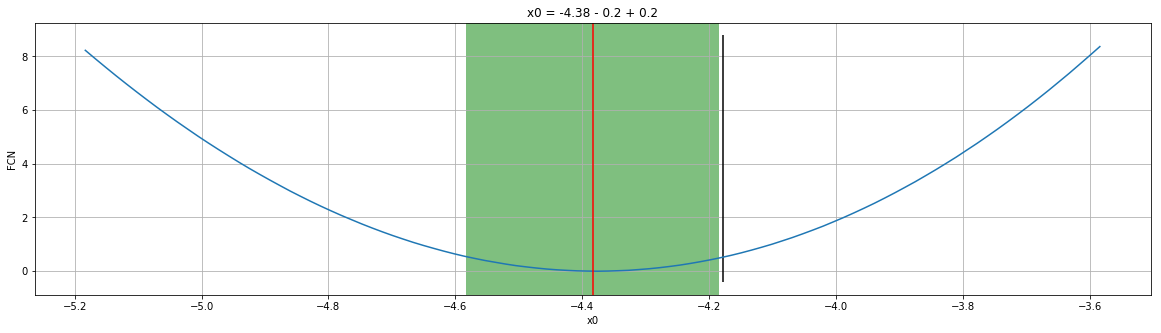

100%|██████████| 4/4 [00:16<00:00,  4.04s/it]


In [12]:
param2=[]
paramTF=[]
paramMIGRAD=[]
paramERRS=[]
MINUIT=[]

#perform nfit tf fits 
nfit=4
plt.rcParams["figure.figsize"] = (20,5)

for j in tqdm(range(nfit)):
    
    #fit with TF
    optimizer , coeffsTF =toySM.tf_fit(init= 'SAME SIGN' , fixed=fix_one_alpha)
    #finish fit with migrad to get profile errors 
    minuit , coeffsMIGRAD = toySM.minuitfit(Ncall=10000 , fixed=fix_one_alpha , coefini=coeffsTF)
    
    MINUIT.append(minuit)
    
    paramTF.append(coeffsTF)
    paramMIGRAD.append(coeffsMIGRAD)
    param2.append(coeffsMIGRAD)
    
    paramERRS.append(minuit.np_errors())    
    
    
    x , y = minuit.draw_profile('x0' , subtract_min=True , bound=4)
    ax=plt.gca()
    ymin, ymax = ax.get_ylim()
    ax.vlines(CoeffSM[0] , ymin , ymax)
    plt.show()
    
    

In [13]:
print(paramTF)

[[-4.415489, -0.15184344, 6.8183246, 0.008585378, -0.0018230017, 0.4660742, -0.23538125, -0.0043176315, 8.003745, 0.16564202, -0.013095878, -0.30668017, 3.8864067, 0.08526551, -8.197446, -0.09505176, 0.007934013, -0.07297003, -0.4235836, 0.027298994, -7.147451, 0.0, 0.0, 0.0, 6.9508157, -0.2278163, 9.89863, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [-4.3767805, -0.15184344, 6.8183246, 0.008585378, -0.0018230017, 0.4660742, -0.23538125, -0.0043176315, 8.003745, 0.16564202, -0.013095878, -0.30668017, 3.8864067, 0.08526551, -8.197446, -0.09505176, 0.007934013, -0.07297003, -0.4235836, 0.027298994, -7.147451, 0.0, 0.0, 0.0, 6.920687, -0.2278163, 9.89863, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0], [-4.3755903, -0.15184344, 6.8183246, 0.008585378, -0.0018230017, 0.4660742, -0.23538125, -0.0043176315, 8.003745, 0.16564202, -0.013095878, -0.30668017, 3.8864067, 0.08526

In [1]:
param2=np.asarray(param2)
paramTF=np.asarray(paramTF)
paramMIGRAD=np.asarray(paramMIGRAD)
paramERRS=np.asarray(paramERRS)
Title=Standard_labels(amplitude_names)

print(param2[:,0])
print(paramERRS[:,0])
weights=1/paramERRS
print(weights[:,0])
av0=np.average(param2[:,0])
avW=np.average(param2[:,0] , weights= weights[:,0])
print('AV_0' , av0)
print('AV_W' , avW)

for j in range(len(param2[0])):
    if fix_one_alpha[j]==0:
        err=np.sqrt(sum(paramERRS[:,j]**2))/nfit 
        print(Title[j])
        print('INIT : ' , toySM.coeffs[j], '\n' , 'FIT : ' , np.mean(param2[:,j]) , 'pm' , np.std(param2[:,j])/np.sqrt(nfit))
        print('(err)' , np.mean(param2[:,j]) , 'pm' , err , '\n' )
        plt.show()

NameError: name 'np' is not defined

## ... for alphas varying (12 parameters)

In [15]:
param12=[]
paramTF=[]
paramMIGRAD=[]
paramERRS=[]
MINUIT=[]

#perform nfit tf fits 
nfit=2
for j in tqdm(range(nfit)):
    
    #fit with TF
    optimizer , coeffsTF =toySM.tf_fit(init= 'SAME SIGN' , fixed=fix_alphas)
    #finish fit with migrad to get profile errors 
    minuit , coeffsMIGRAD = toySM.minuitfit(Ncall=10000 , init= 'SAME SIGN' , fixed=fix_alphas , coefini=coeffsTF)
    
    MINUIT.append(minuit)
    
    paramTF.append(coeffsTF)
    paramMIGRAD.append(coeffsMIGRAD)
    param12.append(coeffsTF)
    
    paramERRS.append(minuit.np_errors())    
    
    '''
    x , y = minuit.draw_profile('x0' , subtract_min=True)
    plt.show()
    '''
    

100%|██████████| 2/2 [00:14<00:00,  6.94s/it]


In [16]:
param12=np.asarray(param12)
paramTF=np.asarray(paramTF)
paramMIGRAD=np.asarray(paramMIGRAD)
paramERRS=np.asarray(paramERRS)
Title=Standard_labels(amplitude_names)


plt.rcParams["figure.figsize"] = (20,5)

for j in range(len(param12[0])):
    if fix_alphas[j]==0:
        err=np.sqrt(sum(paramERRS[:,j]**2))/nfit 
        print(Title[j])
        print('INIT : ' , toySM.coeffs[j], '\n' , 'FIT : ' , np.mean(param12[:,j]) , 'pm' , np.std(param12[:,j])/np.sqrt(nfit))
        print('(err)' , np.mean(param12[:,j]) , 'pm' , err , '\n' )
        plt.show()

alpha(a_para_l_re)
INIT :  -4.1781025 
 FIT :  -4.2924623 pm 0.00039618037600240385
(err) -4.2924623 pm 0.33813319006677234 

alpha(a_para_l_im)
INIT :  0.008585378 
 FIT :  0.20916271 pm 1.6784982419463546e-05
(err) 0.20916271 pm 0.4689234494935908 

alpha(a_para_r_re)
INIT :  -0.23538125 
 FIT :  0.05805698 pm 0.0023872093534581815
(err) 0.05805698 pm 0.7265091396777416 

alpha(a_para_r_im)
INIT :  0.16564202 
 FIT :  0.238493 pm 0.0018387616334090292
(err) 0.238493 pm 1.6879099757850087 

alpha(a_perp_l_re)
INIT :  3.8864067 
 FIT :  3.826616 pm 0.0006564793124056854
(err) 3.826616 pm 0.35817227521462963 

alpha(a_perp_l_im)
INIT :  -0.09505176 
 FIT :  -0.1141038 pm 0.00010370758911711861
(err) -0.1141038 pm 0.6672440426453531 

alpha(a_perp_r_re)
INIT :  -0.4235836 
 FIT :  0.19099304 pm 0.002066770815496902
(err) 0.19099304 pm 0.6357440103252614 

alpha(a_0_l_re)
INIT :  7.202759 
 FIT :  6.7819777 pm 0.0005858412354604588
(err) 6.7819777 pm 0.6101649759177805 

alpha(a_00_l_re)


## ... for alphas and betas varying (20 parameters)

In [124]:
param20=[]
paramTF=[]
paramMIGRAD=[]
paramERRS=[]
MINUIT=[]

#perform nfit tf fits 
nfit=1
for j in tqdm(range(nfit)):
    
    #fit with TF
    optimizer , coeffsTF =toySM.tf_fit(init= 'SAME SIGN' , fixed=fix_alphas)
    #finish fit with migrad to get profile errors 
    minuit , coeffsMIGRAD = toySM.minuitfit(Ncall=10000 , init= 'SAME SIGN' , fixed=fix_alphas , coefini=coeffsTF)
    
    MINUIT.append(minuit)
    
    paramTF.append(coeffsTF)
    paramMIGRAD.append(coeffsMIGRAD)
    param20.append(coeffsTF)
    
    paramERRS.append(minuit.np_errors())    
    
    '''
    x , y = minuit.draw_profile('x0' , subtract_min=True)
    plt.show()
    '''
    



  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:19<00:00, 19.18s/it]

In [125]:
param20=np.asarray(param20)
paramTF=np.asarray(paramTF)
paramMIGRAD=np.asarray(paramMIGRAD)
paramERRS=np.asarray(paramERRS)
Title=Standard_labels(amplitude_names)


plt.rcParams["figure.figsize"] = (20,5)

for j in range(len(param20[0])):
    if fix_alphas[j]==0:
        err=np.sqrt(sum(paramERRS[:,j]**2))/nfit 
        print(Title[j])
        print('INIT : ' , toySM.coeffs[j], '\n' , 'FIT : ' , np.mean(param20[:,j]) , 'pm' , np.std(param20[:,j])/np.sqrt(nfit))
        print('(err)' , np.mean(param20[:,j]) , 'pm' , err , '\n' )
        plt.show()

alpha(a_para_l_re)
INIT :  -4.1781025 
 FIT :  -4.134117 pm 0.0
(err) -4.134117 pm 0.14679416890092528 

alpha(a_para_l_im)
INIT :  0.008585378 
 FIT :  0.007407184 pm 0.0
(err) 0.007407184 pm 0.08508780908307621 

alpha(a_para_r_re)
INIT :  -0.23538125 
 FIT :  -0.28327706 pm 0.0
(err) -0.28327706 pm 0.21019287351334387 

alpha(a_para_r_im)
INIT :  0.16564202 
 FIT :  0.2397111 pm 0.0
(err) 0.2397111 pm 0.6200996527560904 

alpha(a_perp_l_re)
INIT :  3.8864067 
 FIT :  3.9101734 pm 0.0
(err) 3.9101734 pm 0.14726635396979246 

alpha(a_perp_l_im)
INIT :  -0.09505176 
 FIT :  -0.13358983 pm 0.0
(err) -0.13358983 pm 0.2160292128304506 

alpha(a_perp_r_re)
INIT :  -0.4235836 
 FIT :  -0.4746268 pm 0.0
(err) -0.4746268 pm 0.13610825010435004 

alpha(a_0_l_re)
INIT :  7.202759 
 FIT :  7.1918054 pm 0.0
(err) 7.1918054 pm 0.19019033482746486 

alpha(a_00_l_re)
INIT :  1.0 
 FIT :  0.9886341 pm 0.0
(err) 0.9886341 pm 0.1013051492396965 

alpha(a_00_l_im)
INIT :  1.0 
 FIT :  0.91633004 pm 0.0
